In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from transformer.models import Transformer
from transformer.utils import get_pos, cal_bleu, draw_attentions

import matplotlib.pyplot as plt

from main import argument_parsing
from dataloader import get_data

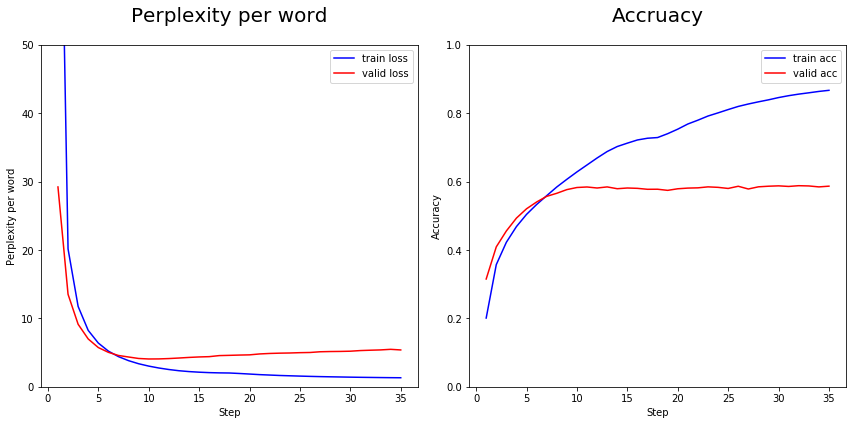

In [2]:
array = np.loadtxt("../trainlog/losses-accs-model-multi30k.txt")
train_loss = array[0]
train_accs = array[1]
valid_loss = array[2]
valid_accs = array[3]

fig, axes = plt.subplots(1, 2, figsize=(12, 6) , sharex=True)
ax1, ax2 = axes
xx = np.arange(1, 36)
ax1.plot(xx, np.exp(train_loss), 'b', label="train loss")
ax1.plot(xx, np.exp(valid_loss), 'r', label="valid loss")
ax1.set_ylim(0, 50)
ax1.set_ylabel("Perplexity per word")
ax1.set_xlabel("Step")
ax1.set_title("Perplexity per word", fontsize=20, y=1.05)
ax1.legend()
ax2.plot(xx, train_accs, 'b', label="train acc")
ax2.plot(xx, valid_accs, 'r', label="valid acc")
ax2.set_ylim(0.0, 1)
ax2.set_ylabel("Accuracy")
ax2.set_xlabel("Step")
ax2.set_title("Accruacy", fontsize=20,  y=1.05)
ax2.legend()
plt.tight_layout()
plt.show()
fig.savefig("../figs/perplexity-acc.png")

In [14]:
arguments = " ".join([s.strip() for s in Path("../run-main.sh").read_text().replace("\\", "").replace('"', "").replace("./", "../").splitlines()[1:-1]])

In [15]:
parser = argument_parsing(preparse=True)
args = parser.parse_args(arguments.split())

In [16]:
args

Namespace(batch=128, beta1=0.9, beta2=0.98, d_f=2048, d_k=64, d_model=512, d_v=64, data_type='multi30k', dec_eos_idx=3, dec_sos_idx=2, drop_rate=0.1, embed_weight_share=False, enc_eos_idx=None, enc_sos_idx=None, linear_weight_share=False, load_path=None, max_length=50, metrics_method='acc', min_freq=5, n_head=8, n_layer=6, n_step=35, pad_idx=1, pos_pad_idx=0, root_dir='../data', save_path='../saved_model/model-multi30k.pt', smooth_eps=0.1, use_conv=False, use_cuda=True, verbose=1, warmup_steps=4000)

In [17]:
device = "cuda" if (torch.cuda.is_available() and args.use_cuda) else "cpu"
# device = "cpu"
(src, trg), (train, valid, test), (train_loader, valid_loader, test_loader) = get_data(args)
src_vocab_len = len(src.vocab.stoi)
trg_vocab_len = len(trg.vocab.stoi)
enc_max_seq_len = args.max_length
dec_max_seq_len = args.max_length
pad_idx = src.vocab.stoi.get("<pad>") if args.pad_idx is None else args.pad_idx
enc_sos_idx = src.vocab.stoi.get("<s>") if args.enc_sos_idx is None else args.enc_sos_idx
enc_eos_idx = src.vocab.stoi.get("</s>") if args.enc_eos_idx is None else args.enc_eos_idx
dec_sos_idx = trg.vocab.stoi.get("<s>") if args.dec_sos_idx is None else args.dec_sos_idx
dec_eos_idx = trg.vocab.stoi.get("</s>") if args.dec_eos_idx is None else args.dec_eos_idx
pos_pad_idx = 0 if args.pos_pad_idx is None else args.pos_pad_idx

model = Transformer(enc_vocab_len=src_vocab_len, 
                    enc_max_seq_len=enc_max_seq_len, 
                    dec_vocab_len=trg_vocab_len, 
                    dec_max_seq_len=dec_max_seq_len, 
                    n_layer=args.n_layer, 
                    n_head=args.n_head, 
                    d_model=args.d_model, 
                    d_k=args.d_k, 
                    d_v=args.d_v, 
                    d_f=args.d_f, 
                    pad_idx=pad_idx,
                    pos_pad_idx=pos_pad_idx, 
                    drop_rate=args.drop_rate, 
                    use_conv=args.use_conv, 
                    linear_weight_share=args.linear_weight_share, 
                    embed_weight_share=args.embed_weight_share).to(device)

In [18]:
if device == "cuda":
    model.load_state_dict(torch.load(args.save_path))
else:
    model.load_state_dict(torch.load(args.save_path, map_location=torch.device(device)))

## BLEU scores

In [7]:
from transformer.bleu import compute_bleu

In [33]:
with torch.no_grad():
    bleu = 0.0
    for batch in test_loader:
        src_pos = get_pos(batch.src, model.pad_idx, enc_sos_idx, enc_eos_idx)
        trg_pos = get_pos(batch.trg, model.pad_idx, dec_sos_idx, dec_eos_idx)
        
        output = model(batch.src, src_pos, batch.trg, trg_pos)
        pred = output.argmax(-1)
        real_trg = batch.trg[:, 1:].contiguous()
        # get list sents
        pred_sents = get_lists(pred, real_trg.ne(1))
        trg_sents = get_lists(real_trg, real_trg.ne(1))
        bleu += compute_bleu(reference_corpus=[[sent] for sent in trg_sents], translation_corpus=pred_sents, max_order=3, smooth=False)[0]

In [34]:
bleu

12.74186740852315

## Greedy Decode

In [57]:
rand_idx = torch.randint(0, len(test), (1,))
rand_data = test.examples[rand_idx]

In [64]:
rand_idx

tensor([440])

In [58]:
def greedy_decode(args, model, src_data, trg_data, src_field, trg_field, 
                  enc_sos_idx=None, enc_eos_idx=None, dec_sos_idx=None, dec_eos_idx=None, device='cpu'):
    
    def get_real_attn(maxlen, attns_list):
        return [attn[:, :, :maxlen, :maxlen] for attn in attns_list]
        
    src_tensor = src_field.process([src_data]).to(device)
    trg_tensor = trg_field.process([trg_data]).to(device)
    # calculate real max lengths of sentences
    src_maxlen = src_tensor.ne(1).sum().item()
    trg_maxlen = trg_tensor.ne(1).sum().item()
    # get src sentence positions
    src_pos = get_pos(src_tensor, model.pad_idx, enc_sos_idx, enc_eos_idx)
    
    model.eval()
    decodes = []
    dec_tensor = torch.LongTensor([trg_field.vocab.stoi['<s>']]).unsqueeze(0).to(device)
    dec_pos = get_pos(dec_tensor, model.pad_idx, dec_sos_idx, dec_eos_idx)
    
    with torch.no_grad():
        enc_output, enc_self_attns = model.encoder(src_tensor, src_pos, return_attn=True)
        for i in range(args.max_length-1):
            dec_output, (dec_self_attns, dec_enc_attns) = \
                model.decoder(dec_tensor, dec_pos, src_tensor, enc_output, return_attn=True)
            output = model.projection(dec_output[:, -1])
            pred = output.argmax(-1)
            if pred.item() == dec_eos_idx:
                break
            else:
                dec_tensor = torch.cat([dec_tensor, pred.unsqueeze(-1)], dim=1)
                dec_pos = get_pos(dec_tensor, model.pad_idx, dec_sos_idx, dec_eos_idx)        
            
    attns_dict = {'enc_self_attns': get_real_attn(src_maxlen, enc_self_attns), 
                  'dec_self_attns': get_real_attn(trg_maxlen, dec_self_attns),
                  'dec_enc_attns': get_real_attn(trg_maxlen, dec_enc_attns)}
    return dec_tensor, attns_dict

In [59]:
dec_tensor, attns_dict = \
    greedy_decode(args, model, src_data=rand_data.src, trg_data=rand_data.trg,
                  src_field=src, trg_field=trg, device=device)

In [60]:
print("Source Sentence:")
print("  ","".join(rand_data.src).strip().replace("  ", " "))
print("Target Sentence:")
print("  ","".join(rand_data.trg).strip().replace("  ", " "))
print("Predicted Sentence:")
print("  ",trg.reverse(dec_tensor)[0])

Source Sentence:
   a woman is playing volleyball .
Target Sentence:
   eine frau spielt volleyball .
Predicted Sentence:
   eine frau spielt volleyball.


------------------------------
 Layer 0


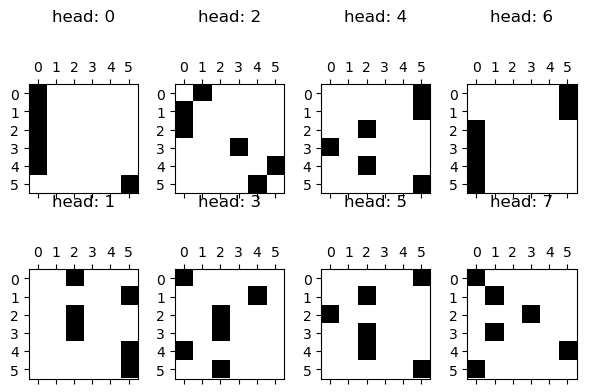

------------------------------
 Layer 1


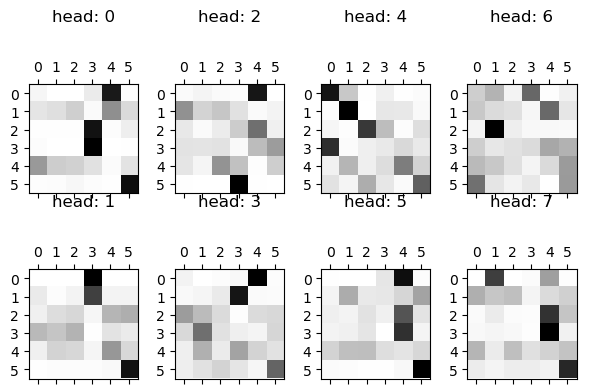

------------------------------
 Layer 2


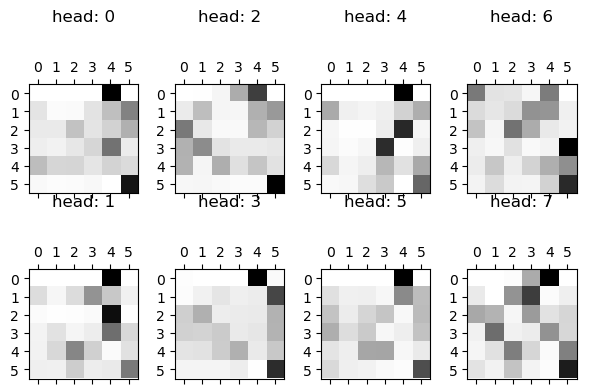

------------------------------
 Layer 3


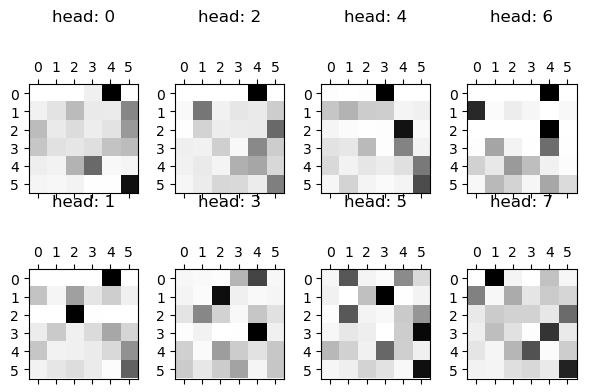

------------------------------
 Layer 4


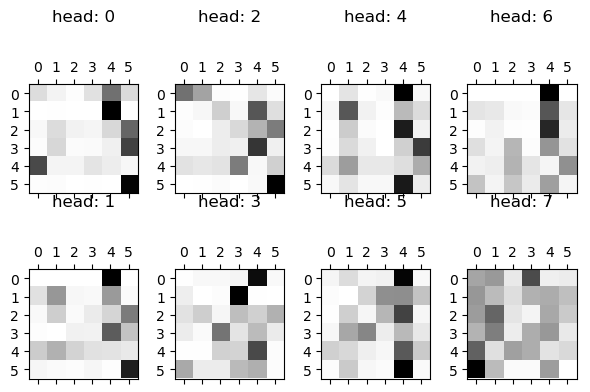

------------------------------
 Layer 5


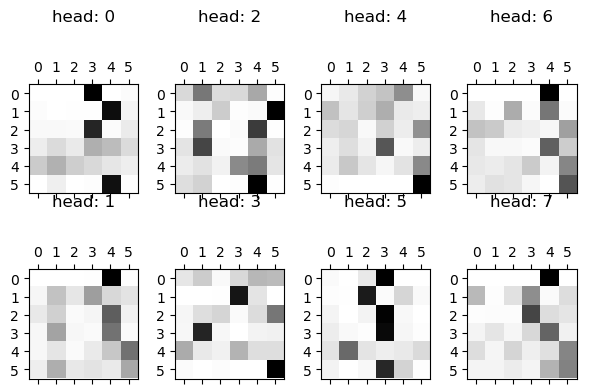

In [61]:
draw_str = "enc_self_attns"

for i in range(len(attns_dict[draw_str])):
    print(f"{'-'*30}\n Layer {i}")
    draw_attentions(n_head=8, attn=attns_dict[draw_str][i].cpu())

------------------------------
 Layer 0


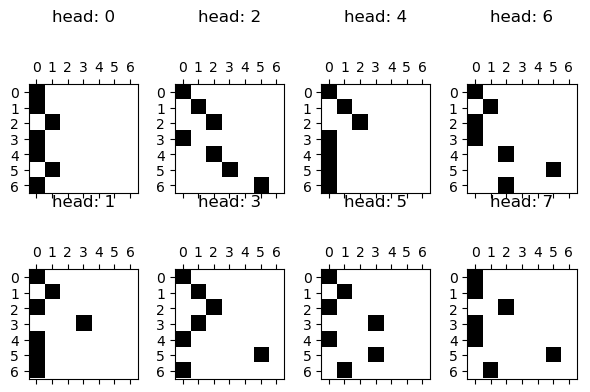

------------------------------
 Layer 1


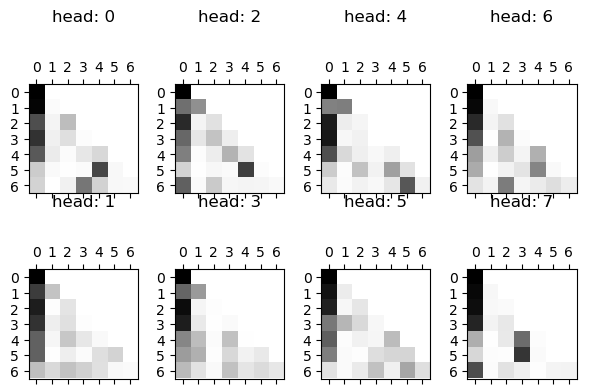

------------------------------
 Layer 2


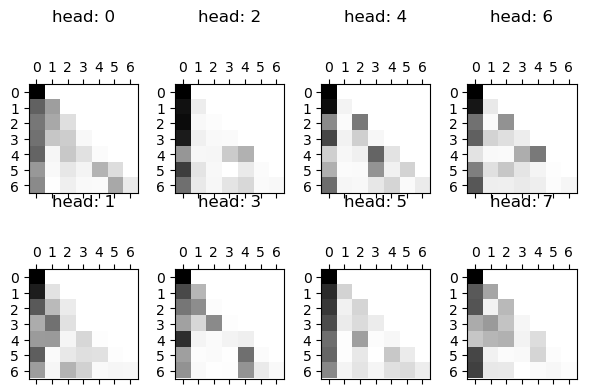

------------------------------
 Layer 3


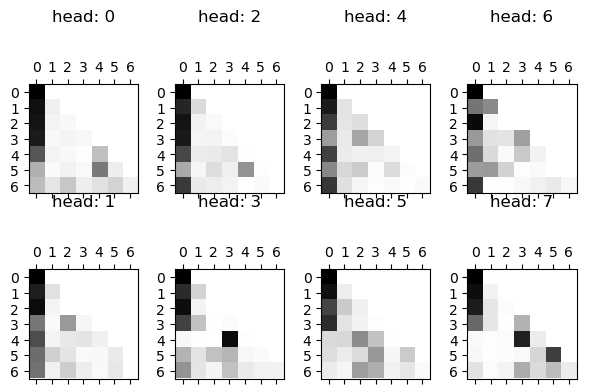

------------------------------
 Layer 4


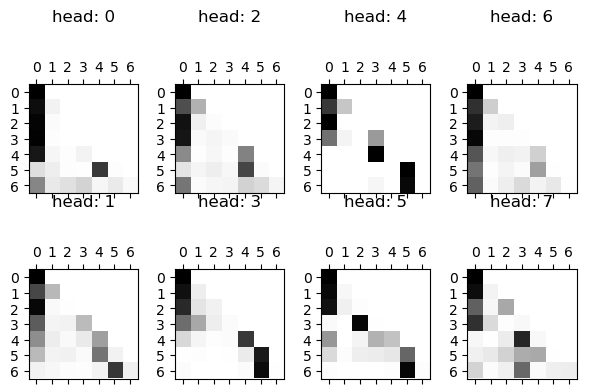

------------------------------
 Layer 5


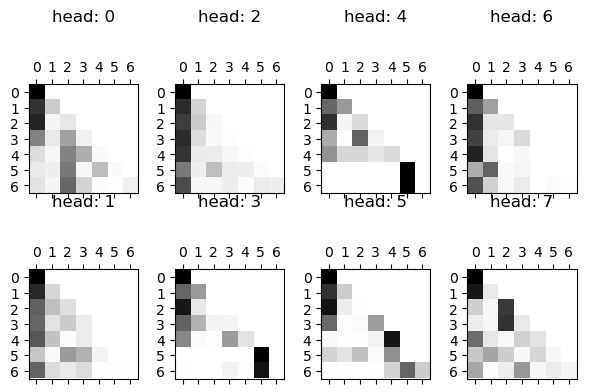

In [62]:
draw_str = "dec_self_attns"

for i in range(len(attns_dict[draw_str])):
    print(f"{'-'*30}\n Layer {i}")
    draw_attentions(n_head=8, attn=attns_dict[draw_str][i].cpu())

------------------------------
 Layer 0


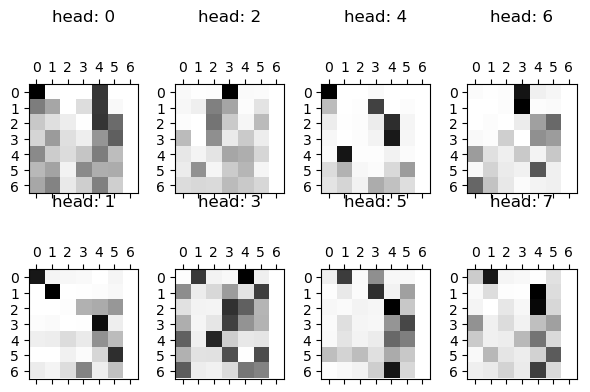

------------------------------
 Layer 1


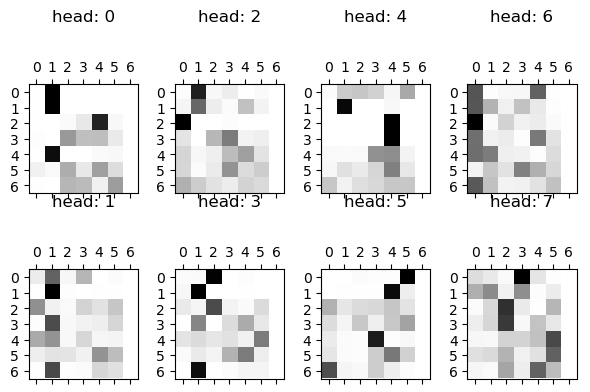

------------------------------
 Layer 2


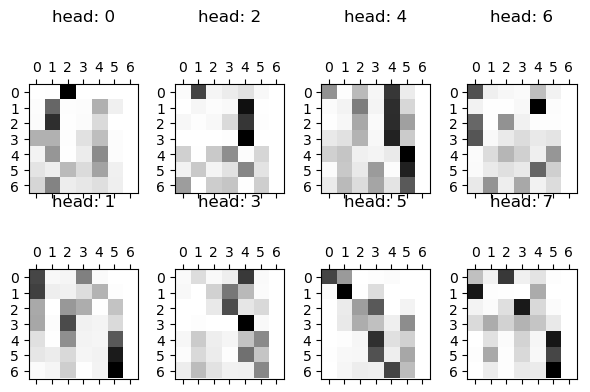

------------------------------
 Layer 3


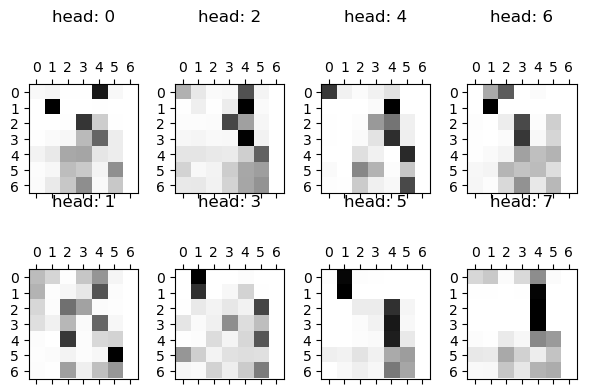

------------------------------
 Layer 4


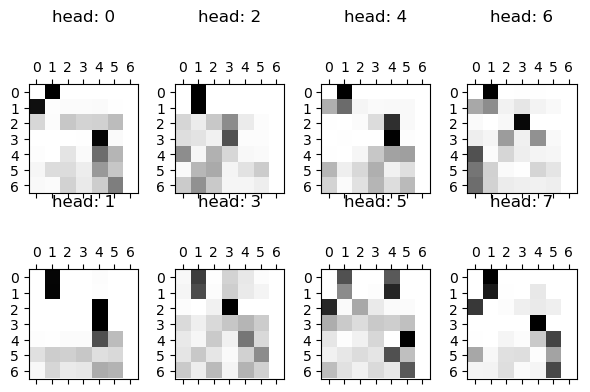

------------------------------
 Layer 5


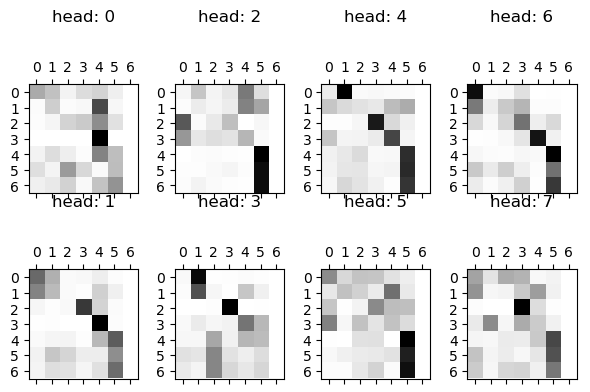

In [63]:
draw_str = "dec_enc_attns"

for i in range(len(attns_dict[draw_str])):
    print(f"{'-'*30}\n Layer {i}")
    draw_attentions(n_head=8, attn=attns_dict[draw_str][i].cpu())